### Possums

<center>
<img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Trichosurus_vulpecula_1.jpg/440px-Trichosurus_vulpecula_1.jpg' width = 30%/>
</center>



*The common brushtail possum (Trichosurus vulpecula, from the Greek for "furry tailed" and the Latin for "little fox", previously in the genus Phalangista) is a nocturnal, semi-arboreal marsupial of the family Phalangeridae, native to Australia, and the second-largest of the possums.* -- from Wikipedia.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import Logit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/possum.csv').dropna()

In [3]:
df.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


### Task

1. Examine distributions for outliers, remove any you believe should be.
2. Build Logistic Regression model to predict `pop`; region of origin.  Make sure to include a model on all the features, and examine the coefficients.
3. Rerun a model without the head variable, did any of the coefficients change?  Why do you think this is?

### Basic EDA and outlier removal

In [4]:
df['site'].value_counts()

1    33
7    18
5    13
6    13
2    11
3     7
4     7
Name: site, dtype: int64

In [5]:
df['pop'].value_counts()

other    58
Vic      44
Name: pop, dtype: int64

In [6]:
df['sex'].value_counts()

m    59
f    43
Name: sex, dtype: int64

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


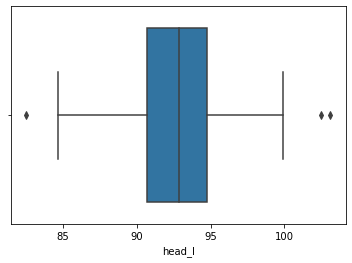

In [16]:
sns.boxplot(df['head_l']);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


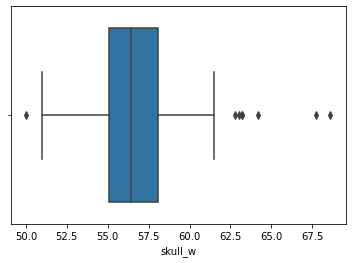

In [12]:
sns.boxplot(df['skull_w']);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


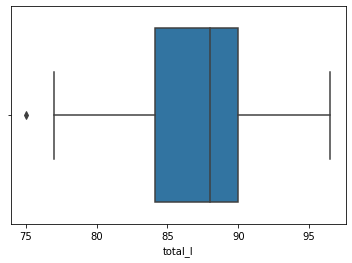

In [14]:
sns.boxplot(df['total_l']);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


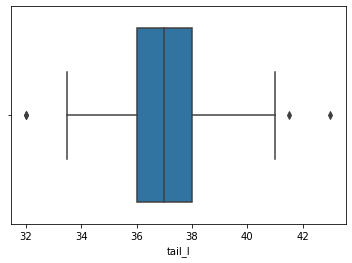

In [15]:
sns.boxplot(df['tail_l']);

In [ ]:
# remove skull_w outliers


In [19]:
mean = df['skull_w'].mean()
std = df['skull_w'].std()
skullw_max = mean + (1.5 * std)
skullw_min = mean - (1.5 * std)

In [20]:
skullw_max

61.591709267657045

In [21]:
skullw_min

52.329859359793964

In [27]:
df_rmv_outliers = df[(df['skull_w'] <= skullw_max) & (df['skull_w'] >=skullw_min)]

### Create binary features

In [32]:
# 1 for Vic, 0 for other
df_rmv_outliers['pop_binary']= np.where(df_rmv_outliers['pop'] == 'Vic', 1, 0)

/var/folders/kz/klxfgxt54zg3ld3hw3501lf80000gp/T/ipykernel_46856/2389044585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rmv_outliers['pop_binary']= np.where(df_rmv_outliers['pop'] == 'Vic', 1, 0)


In [59]:
df_rmv_outliers['pop'].value_counts()

other    48
Vic      42
Name: pop, dtype: int64

In [58]:
df_rmv_outliers['pop_binary'].value_counts()

0    48
1    42
Name: pop_binary, dtype: int64

In [51]:
# 1 for female, 0 for male
df_rmv_outliers['sex_binary']= np.where(df_rmv_outliers['sex'] == 'm', 0, 1)

/var/folders/kz/klxfgxt54zg3ld3hw3501lf80000gp/T/ipykernel_46856/1158431056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rmv_outliers['sex_binary']= np.where(df_rmv_outliers['sex'] == 'm', 0, 1)


### Examine some features

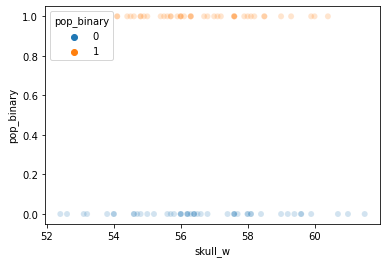

In [52]:
sns.scatterplot(x='skull_w', y='pop_binary', data=df_rmv_outliers, hue='pop_binary', alpha=.2);


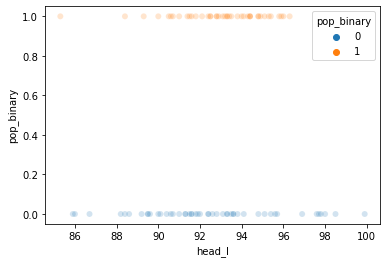

In [53]:
sns.scatterplot(x='head_l', y='pop_binary', data=df_rmv_outliers, hue='pop_binary', alpha=.2);


### build model

In [90]:
df_rmv_outliers.columns

Index(['site', 'pop', 'sex', 'age', 'head_l', 'skull_w', 'total_l', 'tail_l',
       'pop_binary', 'sex_binary'],
      dtype='object')

In [91]:
features = ['sex_binary', 'age', 'head_l', 'skull_w', 'total_l', 'tail_l']
X = df_rmv_outliers.loc[:, features]
y = df_rmv_outliers['pop_binary']

In [92]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [93]:
lgr = LogisticRegression().fit(X_train, y_train)
# the iterations message is a warning- you can set the max iter parameter to a bigger
# number
# the default number this will iterate ia 1000
# you can scale your data

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### evaluate

In [94]:
lgr.coef_

array([[ 0.57186672,  0.11501921, -0.1486778 , -0.09874475,  0.60397099,
        -1.67550452]])

In [95]:
lgr.intercept_

array([27.6770744])

In [96]:
lgr.score(X_train, y_train)

0.8656716417910447

In [97]:
lgr.score(X_train, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [23, 67]

In [73]:
lgr.predict_proba(X_test)

array([[0.00722362, 0.99277638],
       [0.09821202, 0.90178798],
       [0.72372712, 0.27627288],
       [0.90122828, 0.09877172],
       [0.11128134, 0.88871866],
       [0.03478913, 0.96521087],
       [0.05277766, 0.94722234],
       [0.66443187, 0.33556813],
       [0.82127322, 0.17872678],
       [0.70760456, 0.29239544],
       [0.6107998 , 0.3892002 ],
       [0.27372838, 0.72627162],
       [0.39432733, 0.60567267],
       [0.99816554, 0.00183446],
       [0.12616053, 0.87383947],
       [0.34592774, 0.65407226],
       [0.70281127, 0.29718873],
       [0.01766753, 0.98233247],
       [0.97858598, 0.02141402],
       [0.54402276, 0.45597724],
       [0.99775229, 0.00224771],
       [0.76745538, 0.23254462],
       [0.98669585, 0.01330415]])

### run again but without the skull variable

In [98]:
features2 = ['sex_binary', 'age', 'head_l', 'total_l', 'tail_l']
X = df_rmv_outliers.loc[:, features2]
y = df_rmv_outliers['pop_binary']

In [99]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [100]:
lgr2 = LogisticRegression().fit(X_train, y_train)

### evaluate

In [101]:
lgr2.coef_

array([[ 0.19977406,  0.06950114, -0.2870463 ,  0.64995523, -1.72755746]])

In [79]:
lgr.intercept_

array([26.65290796])

In [80]:
lgr.score(X_train, y_train)

0.8805970149253731

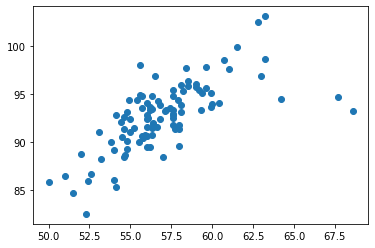

In [103]:
plt.scatter(df['skull_w'], df['head_l']);